# The Multi-Armed Bandit Problem — A Visual Walkthrough
---

### The scenario

You just uploaded a YouTube video and prepared **5 thumbnail candidates**. Each thumbnail has a different — unknown — **click-through rate (CTR)**: the fraction of viewers who click when they see it in their feed. Every impression is one chance to show a thumbnail. You want to find the best one **as fast as possible** without wasting impressions on bad ones.

This is the multi-armed bandit problem.

**Outline:**
1. Why not just A/B test?
2. Formal definition & regret
3. $\varepsilon$-Greedy
4. UCB1
5. Thompson Sampling
6. Head-to-head comparison
7. Summary

---

## 0. Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use(['science', 'ieee'])
plt.rcParams.update({
    'figure.figsize': (10, 4),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

np.random.seed(42)
print("Ready to go!")

Ready to go!


---
## 1. Why Not Just A/B Test?

The standard approach: split impressions equally across all 5 thumbnails for a few days, then pick the winner. Simple and statistically valid — but during the test, you're sending **equal impressions to every thumbnail, including the bad ones**.

If thumbnail C has an 8% CTR and thumbnail A has a 2% CTR, an equal-split test keeps showing A to 20% of your audience for the entire test. Every impression spent on A instead of C is a potential click lost.

> **A bandit algorithm adapts as it learns:** it starts by exploring all thumbnails, but shifts impressions toward the winners while still occasionally checking the others. Fewer wasted impressions, faster convergence to the best thumbnail.

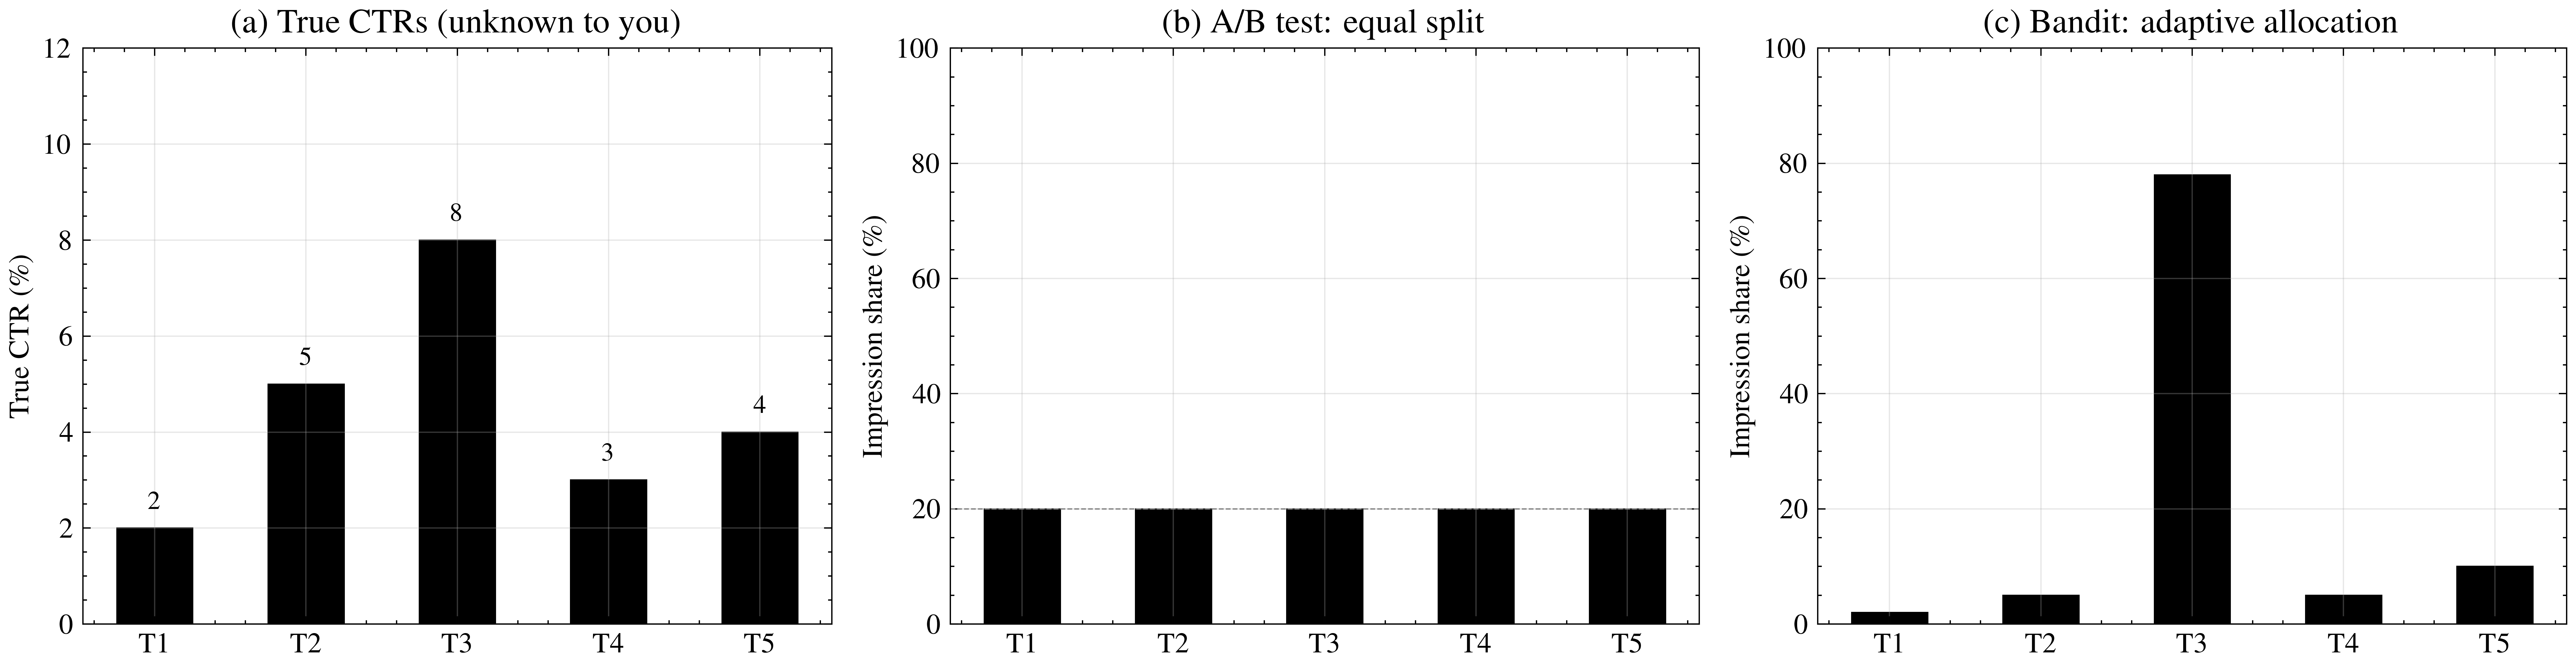

A/B test:     44 clicks from 1000 impressions
All on T3:    80 clicks from 1000 impressions
Gap:          36 clicks lost during the test

A bandit narrows this gap by shifting impressions to T3 as it learns.


In [5]:
np.random.seed(7)

# 5 thumbnail candidates and their true (hidden) CTRs
true_ctrs = [0.02, 0.05, 0.08, 0.03, 0.04]
thumb_names = ['T1', 'T2', 'T3', 'T4', 'T5']

impressions_per = 200
total_impressions = impressions_per * len(true_ctrs)

fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))

# (a) True CTRs
ax = axes[0]
bars = ax.bar(thumb_names, [c*100 for c in true_ctrs], width=0.5,
              edgecolor='black', linewidth=0.6)
ax.set_ylabel('True CTR (\\%)')
ax.set_title('(a) True CTRs (unknown to you)')
ax.set_ylim(0, 12)
for bar, p in zip(bars, true_ctrs):
    ax.text(bar.get_x() + bar.get_width()/2, p*100 + 0.4, f'{p:.0%}',
            ha='center', fontsize=10)

# (b) A/B test: equal split
ax = axes[1]
ab_alloc = np.ones(5) / 5
ax.bar(thumb_names, ab_alloc * 100, width=0.5, edgecolor='black', linewidth=0.6)
ax.set_ylabel('Impression share (\\%)')
ax.set_title('(b) A/B test: equal split')
ax.set_ylim(0, 100)
ax.axhline(20, ls='--', color='grey', lw=0.5)

# (c) Bandit: adaptive
ax = axes[2]
bandit_alloc = [0.02, 0.05, 0.78, 0.05, 0.10]
ax.bar(thumb_names, [a*100 for a in bandit_alloc], width=0.5,
       edgecolor='black', linewidth=0.6)
ax.set_ylabel('Impression share (\\%)')
ax.set_title('(c) Bandit: adaptive allocation')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

ab_clicks = sum(impressions_per * ctr for ctr in true_ctrs)
optimal_clicks = total_impressions * max(true_ctrs)
print(f"A/B test:     {ab_clicks:.0f} clicks from {total_impressions} impressions")
print(f"All on T3:    {optimal_clicks:.0f} clicks from {total_impressions} impressions")
print(f"Gap:          {optimal_clicks - ab_clicks:.0f} clicks lost during the test")
print(f"\nA bandit narrows this gap by shifting impressions to T3 as it learns.")

---
## 2. Formal Definition

You have $K$ thumbnail candidates. Each thumbnail $i$ has a true CTR $\theta_i$ that you don't know. Every time an impression is served (time step $t$), you choose which thumbnail to show (action $a_t$). The viewer either clicks ($r_t = 1$) or scrolls past ($r_t = 0$):

$$P(r_t = 1) = \theta_{a_t}$$

This is a **Bernoulli bandit** — each action gives a binary outcome, like a coin flip with unknown bias.

### Why "Multi-Armed Bandit"?

A "one-armed bandit" is a slot machine — one lever, steals your money. A "multi-armed bandit" is $K$ machines with different hidden payouts. Your 5 thumbnails are your 5 arms.

### Regret

We measure performance by **regret** — the clicks lost by not always showing the best thumbnail:

$$\mathcal{L}_T = \sum_{t=1}^{T}(\theta^* - \theta_{a_t}), \quad \theta^* = \max_i \theta_i$$

### The Estimation Problem

You estimate each thumbnail's CTR from data: $\hat{Q}_t(a) = \text{clicks} / \text{impressions}$. The catch: **early estimates are noisy.**

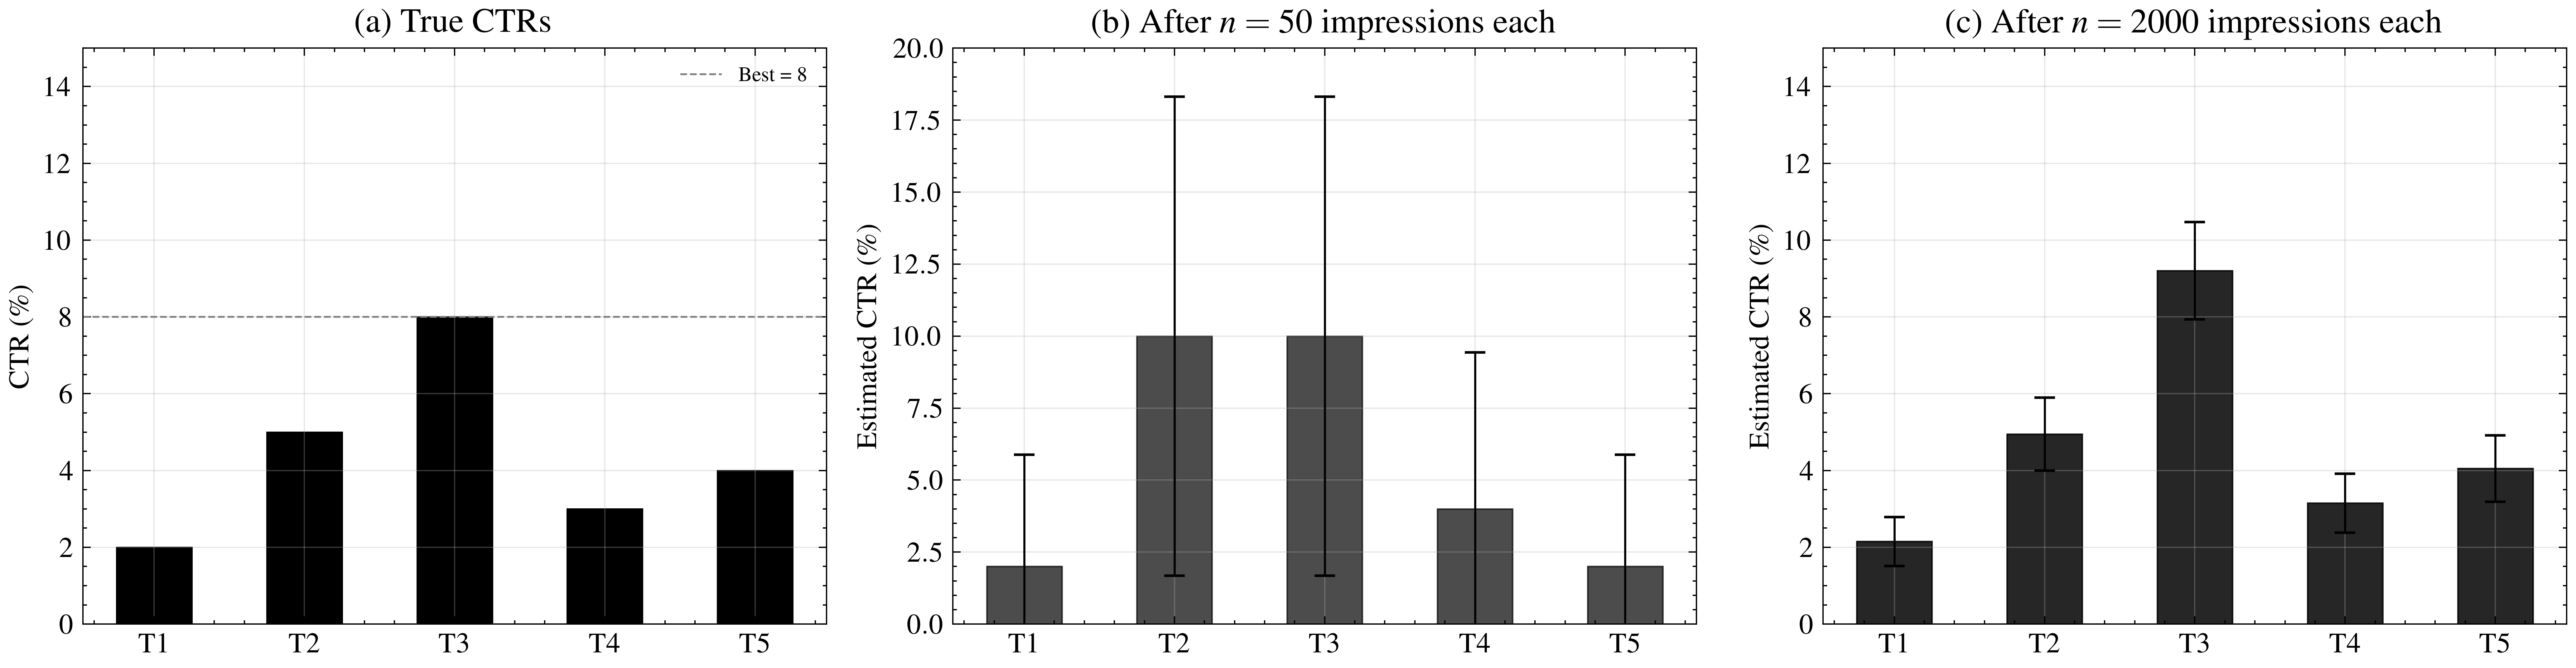

After 50 impressions each: error bars overlap — can't confidently pick the winner.
After 2000 each: tight estimates — but that's 10,000 impressions, mostly wasted.


In [6]:
np.random.seed(42)

K = 5
true_ctrs = [0.02, 0.05, 0.08, 0.03, 0.04]
thumb_names = ['T1', 'T2', 'T3', 'T4', 'T5']

fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))

# (a) True
ax = axes[0]
ax.bar(thumb_names, [c*100 for c in true_ctrs], width=0.5, edgecolor='black', linewidth=0.6)
ax.axhline(max(true_ctrs)*100, ls='--', color='grey', lw=0.7,
           label=f'Best = {max(true_ctrs):.0%}')
ax.set_ylabel('CTR (\\%)')
ax.set_title('(a) True CTRs')
ax.set_ylim(0, 15); ax.legend(fontsize=8)

# (b) After 50 impressions each
ax = axes[1]
n = 50
obs = [np.random.binomial(n, p)/n * 100 for p in true_ctrs]
se = [1.96*np.sqrt((r/100)*(1-r/100)/n)*100 for r in obs]
ax.bar(thumb_names, obs, width=0.5, edgecolor='black', linewidth=0.6, alpha=0.7)
ax.errorbar(thumb_names, obs, yerr=se, fmt='none', ecolor='black', capsize=4, lw=0.8)
ax.set_ylabel('Estimated CTR (\\%)')
ax.set_title(r'(b) After $n=50$ impressions each')
ax.set_ylim(0, 20)

# (c) After 2000 impressions each
ax = axes[2]
n = 2000
obs = [np.random.binomial(n, p)/n * 100 for p in true_ctrs]
se = [1.96*np.sqrt((r/100)*(1-r/100)/n)*100 for r in obs]
ax.bar(thumb_names, obs, width=0.5, edgecolor='black', linewidth=0.6, alpha=0.85)
ax.errorbar(thumb_names, obs, yerr=se, fmt='none', ecolor='black', capsize=4, lw=0.8)
ax.set_ylabel('Estimated CTR (\\%)')
ax.set_title(r'(c) After $n=2000$ impressions each')
ax.set_ylim(0, 15)

plt.tight_layout()
plt.show()

print("After 50 impressions each: error bars overlap — can't confidently pick the winner.")
print("After 2000 each: tight estimates — but that's 10,000 impressions, mostly wasted.")

---
## 3. Algorithm 1: $\varepsilon$-Greedy

Most of the time, show the thumbnail with the highest estimated CTR. Occasionally, try a random one:

$$a_t = \begin{cases} \arg\max_a \hat{Q}_t(a) & \text{w.p. } 1-\varepsilon \quad (\text{show the current best}) \\ \text{random thumbnail} & \text{w.p. } \varepsilon \quad (\text{explore}) \end{cases}$$

Set $\varepsilon = 0.1$ and 10% of impressions go to a random thumbnail.

**Why it's limited:** that random 10% is _blind_. After 10,000 impressions you might know for certain that T1 has a 2% CTR, and $\varepsilon$-Greedy will still randomly show it. Those are wasted impressions.

In [7]:
class BernoulliBandit:
    # K thumbnails with Bernoulli (click/skip) outcomes
    def __init__(self, probs):
        self.probs = np.array(probs)
        self.K = len(probs)
        self.best_prob = np.max(probs)
    def pull(self, arm):
        return 1 if np.random.random() < self.probs[arm] else 0

class EpsilonGreedy:
    def __init__(self, bandit, epsilon=0.1):
        self.bandit = bandit
        self.epsilon = epsilon
        self.counts = np.zeros(bandit.K)
        self.wins = np.zeros(bandit.K)
        self.estimates = np.zeros(bandit.K)
        self.regret_history = []
        self.cumulative_regret = 0
    def run(self, n_steps):
        for _ in range(n_steps):
            if np.random.random() < self.epsilon:
                arm = np.random.randint(self.bandit.K)
            else:
                arm = np.argmax(self.estimates)
            reward = self.bandit.pull(arm)
            self.counts[arm] += 1
            self.wins[arm] += reward
            self.estimates[arm] = self.wins[arm] / self.counts[arm]
            self.cumulative_regret += self.bandit.best_prob - self.bandit.probs[arm]
            self.regret_history.append(self.cumulative_regret)

print("BernoulliBandit and EpsilonGreedy defined.")

BernoulliBandit and EpsilonGreedy defined.


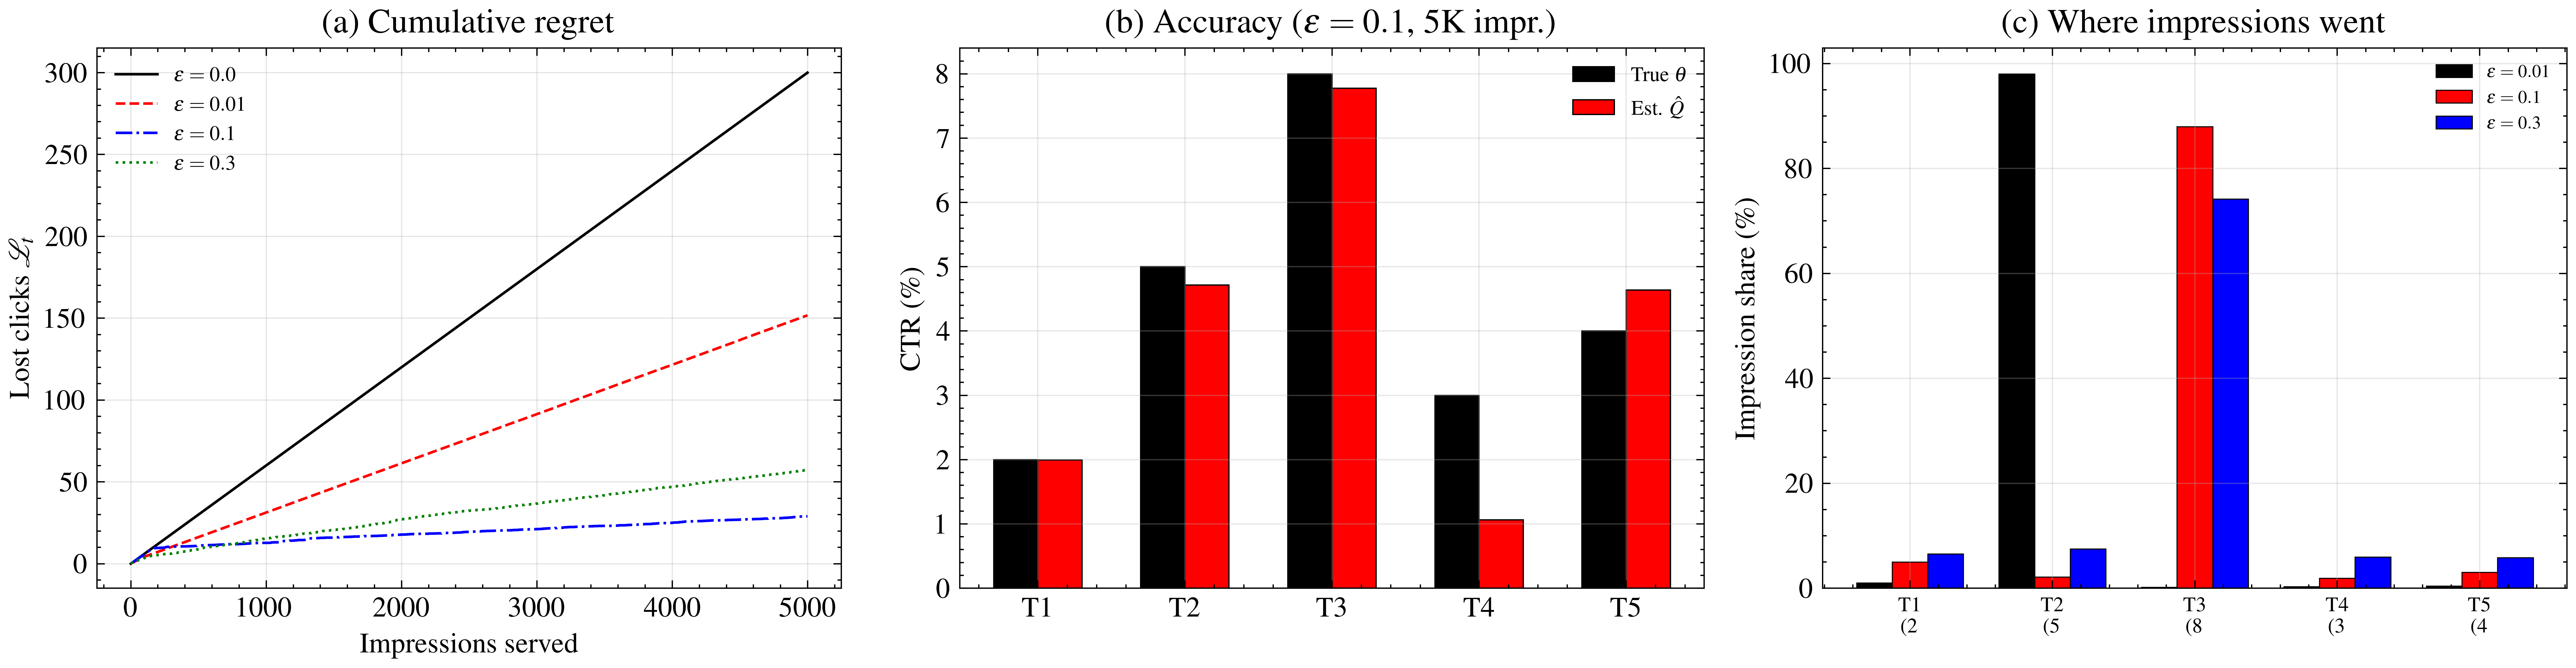

eps=0.0: no exploration -> can get stuck on the wrong thumbnail.
eps=0.3: 30% random -> wastes impressions on thumbnails known to be bad.


In [8]:
np.random.seed(42)

bandit = BernoulliBandit([0.02, 0.05, 0.08, 0.03, 0.04])
thumb_names = ['T1', 'T2', 'T3', 'T4', 'T5']
epsilons = [0.0, 0.01, 0.1, 0.3]
n_steps = 5000

results = {}
for eps in epsilons:
    solver = EpsilonGreedy(bandit, epsilon=eps)
    solver.run(n_steps)
    results[eps] = solver

fig, axes = plt.subplots(1, 3, figsize=(14, 3.8))

# (a) Regret
ax = axes[0]
styles = ['-', '--', '-.', ':']
for eps, ls in zip(epsilons, styles):
    ax.plot(results[eps].regret_history, ls=ls, lw=1.0, label=rf'$\varepsilon={eps}$')
ax.set_xlabel('Impressions served')
ax.set_ylabel(r'Lost clicks $\mathcal{L}_t$')
ax.set_title(r'(a) Cumulative regret')
ax.legend(fontsize=8)

# (b) True vs estimated CTR
ax = axes[1]
solver = results[0.1]
x_pos = np.arange(bandit.K); w = 0.3
ax.bar(x_pos - w/2, [p*100 for p in bandit.probs], w,
       label=r'True $\theta$', edgecolor='black', linewidth=0.5)
ax.bar(x_pos + w/2, [e*100 for e in solver.estimates], w,
       label=r'Est. $\hat{Q}$', edgecolor='black', linewidth=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(thumb_names)
ax.set_ylabel('CTR (\\%)')
ax.set_title(r'(b) Accuracy ($\varepsilon=0.1$, 5K impr.)')
ax.legend(fontsize=8)

# (c) Impression distribution
ax = axes[2]
for i, eps in enumerate([0.01, 0.1, 0.3]):
    fracs = results[eps].counts / results[eps].counts.sum()
    ax.bar(x_pos + (i-1)*0.25, fracs*100, 0.25, label=rf'$\varepsilon={eps}$',
           edgecolor='black', linewidth=0.4)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{t}\n({p:.0%})' for t, p in zip(thumb_names, bandit.probs)], fontsize=8)
ax.set_ylabel('Impression share (\\%)')
ax.set_title('(c) Where impressions went')
ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("eps=0.0: no exploration -> can get stuck on the wrong thumbnail.")
print("eps=0.3: 30% random -> wastes impressions on thumbnails known to be bad.")

---
## 4. Algorithm 2: Upper Confidence Bounds (UCB1)

### Why not explore smarter?

$\varepsilon$-Greedy explores _blindly_. What if we sent impressions specifically to **thumbnails we're still uncertain about?**

### Building the intuition

Imagine this snapshot of your test:

| Thumbnail | Impressions | Clicks | Observed CTR | Confidence |
|-----------|-------------|--------|-------------|------------|
| T1 | 500 | 10 | 2.0% | Very confident — it's bad |
| T2 | 500 | 26 | 5.2% | Pretty confident |
| T3 | 12 | 1 | 8.3% | **Very low — only 12 impressions!** |
| T4 | 500 | 14 | 2.8% | Very confident — it's bad |
| T5 | 500 | 21 | 4.2% | Pretty confident |

T3 _looks_ great at 8.3%, but with only 12 impressions, that could easily be noise. You should show it more to find out.

UCB1 formalizes this: for each thumbnail, compute a score combining the estimated CTR with a measure of uncertainty:

$$a_t = \arg\max_a \underbrace{\hat{Q}_t(a)}_{\text{estimated CTR}} + \underbrace{\sqrt{\frac{2\ln t}{N_t(a)}}}_{\text{how uncertain you are}}$$

The second term is large when $N_t(a)$ is small (few impressions $\to$ uncertain $\to$ explore), and shrinks with more data.

### Where does the uncertainty term come from?

**Hoeffding's Inequality:** given $N$ observations in $[0,1]$, the probability that the true mean exceeds the sample mean by more than $u$ is at most $e^{-2Nu^2}$. Setting this to $t^{-4}$ and solving:

$$e^{-2Nu^2} = t^{-4} \implies u = \sqrt{\frac{2\ln t}{N}}$$

The philosophy: **"optimism in the face of uncertainty"** — act as if each thumbnail is as good as it plausibly could be. Under-explored thumbnails get the benefit of the doubt.

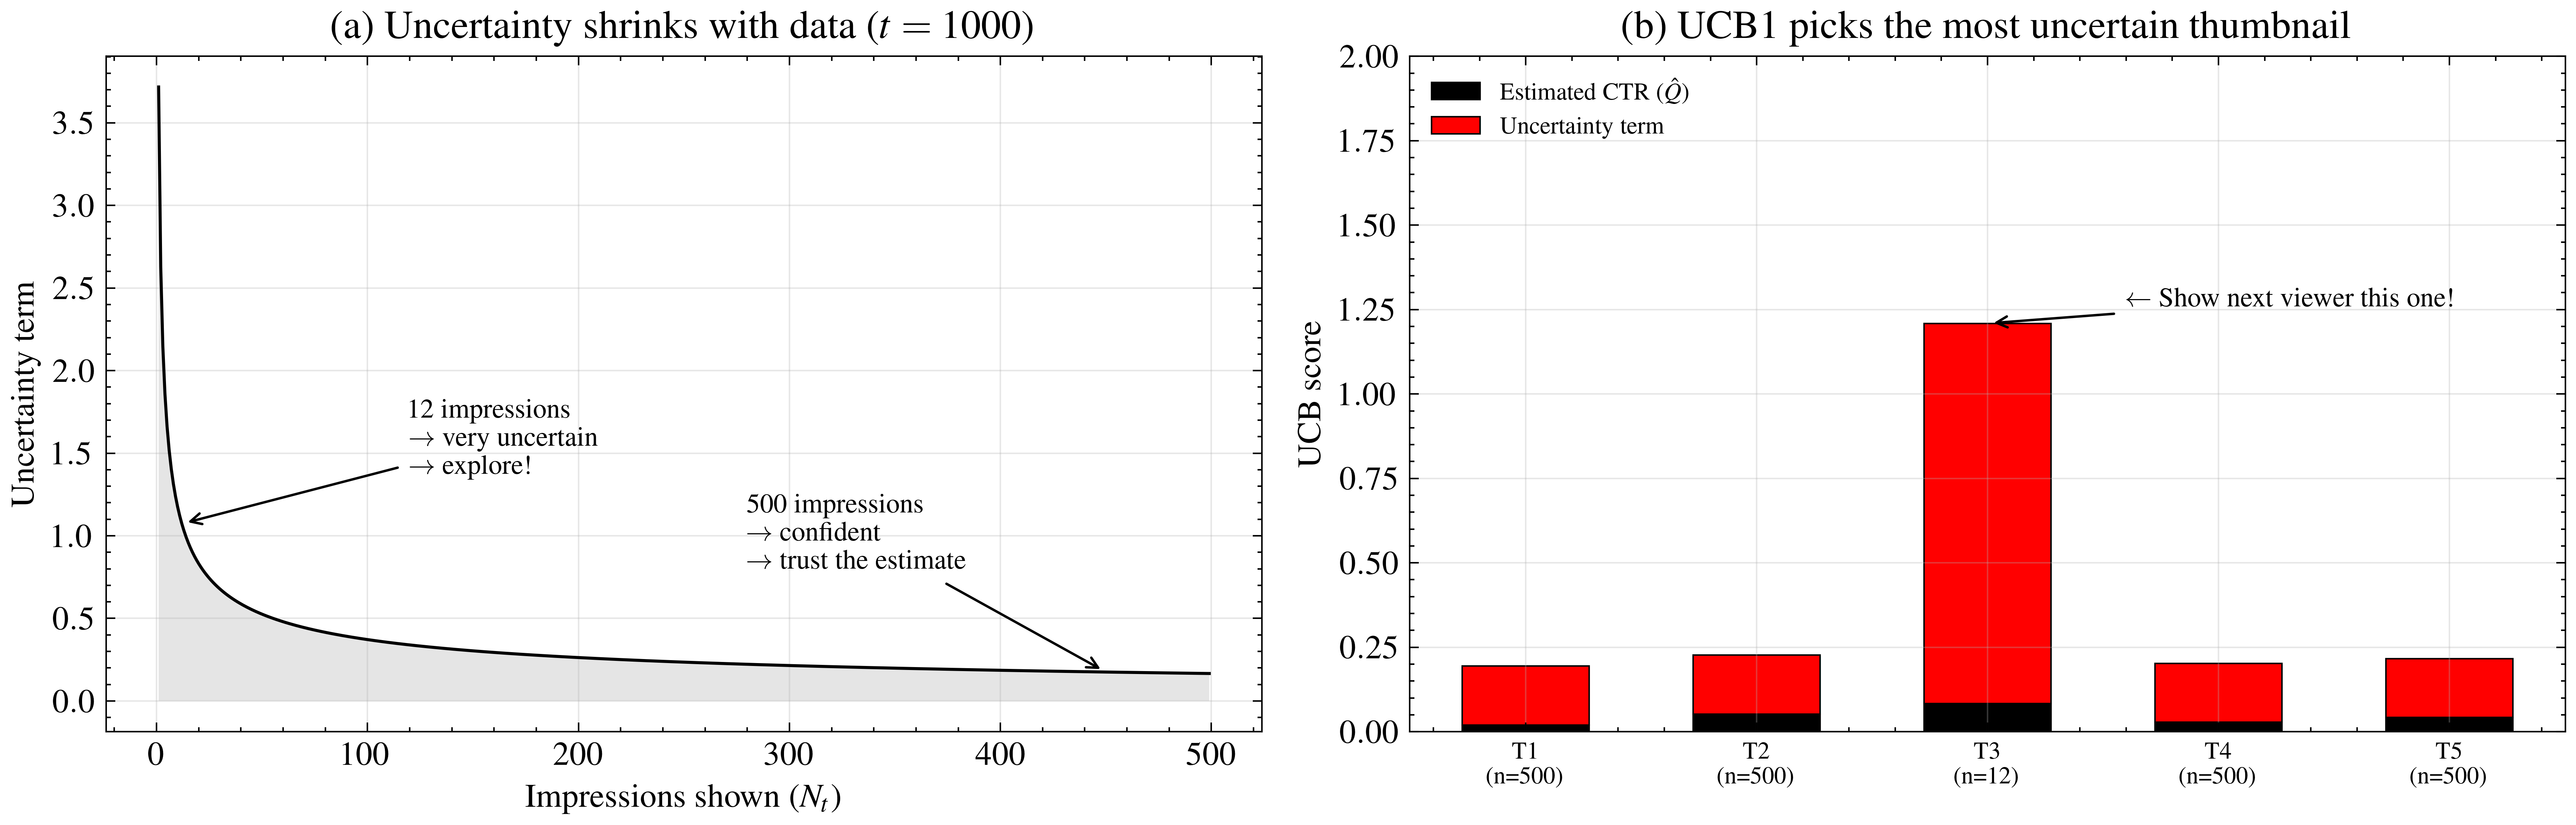

T3: only 12 impressions -> huge uncertainty -> UCB sends impressions there.
T1: 500 impressions, confirmed bad -> tiny uncertainty -> ignored.

This is the key difference from eps-Greedy: exploration is TARGETED, not random.


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) How uncertainty shrinks with impressions
ax = axes[0]
t = 1000
n_values = np.arange(1, 500)
uncertainty = np.sqrt(2 * np.log(t) / n_values)
ax.plot(n_values, uncertainty, 'k-', lw=1.0)
ax.fill_between(n_values, 0, uncertainty, alpha=0.1)
ax.set_xlabel('Impressions shown ($N_t$)')
ax.set_ylabel('Uncertainty term')
ax.set_title(f'(a) Uncertainty shrinks with data ($t={t}$)')
ax.annotate('12 impressions\n$\\to$ very uncertain\n$\\to$ explore!',
            xy=(12, uncertainty[11]), xytext=(120, uncertainty[11]+0.3), fontsize=9,
            arrowprops=dict(arrowstyle='->', lw=0.8))
ax.annotate('500 impressions\n$\\to$ confident\n$\\to$ trust the estimate',
            xy=(450, uncertainty[449]), xytext=(280, 0.8), fontsize=9,
            arrowprops=dict(arrowstyle='->', lw=0.8))

# (b) Concrete UCB scores from the table
ax = axes[1]
thumbs_ex = ['T1\n(n=500)', 'T2\n(n=500)', 'T3\n(n=12)', 'T4\n(n=500)', 'T5\n(n=500)']
estimates = [0.020, 0.052, 0.083, 0.028, 0.042]
n_shown = [500, 500, 12, 500, 500]
t_now = sum(n_shown)
unc = [np.sqrt(2*np.log(t_now)/n) for n in n_shown]
scores = [e+u for e,u in zip(estimates, unc)]

x = np.arange(len(thumbs_ex))
ax.bar(x, estimates, 0.55, label=r'Estimated CTR ($\hat{Q}$)', edgecolor='black', linewidth=0.5)
ax.bar(x, unc, 0.55, bottom=estimates, label='Uncertainty term', edgecolor='black', linewidth=0.5)
ax.set_xticks(x); ax.set_xticklabels(thumbs_ex, fontsize=8)
ax.set_ylim(0, 2)
ax.set_ylabel('UCB score')
ax.set_title('(b) UCB1 picks the most uncertain thumbnail')
ax.legend(fontsize=8, loc='upper left')

winner = np.argmax(scores)
ax.annotate('$\\leftarrow$ Show next viewer this one!',
            xy=(winner, scores[winner]),
            xytext=(winner+0.6, scores[winner]+0.05), fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', lw=0.8))

plt.tight_layout()
plt.show()

print("T3: only 12 impressions -> huge uncertainty -> UCB sends impressions there.")
print("T1: 500 impressions, confirmed bad -> tiny uncertainty -> ignored.")
print("\nThis is the key difference from eps-Greedy: exploration is TARGETED, not random.")

In [11]:
class UCB1:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(bandit.K)
        self.wins = np.zeros(bandit.K)
        self.estimates = np.zeros(bandit.K)
        self.regret_history = []
        self.cumulative_regret = 0
        self.t = 0
    def run(self, n_steps):
        for _ in range(n_steps):
            self.t += 1
            untried = np.where(self.counts == 0)[0]
            if len(untried) > 0:
                arm = untried[0]
            else:
                unc = np.sqrt(2 * np.log(self.t) / self.counts)
                arm = np.argmax(self.estimates + unc)
            reward = self.bandit.pull(arm)
            self.counts[arm] += 1
            self.wins[arm] += reward
            self.estimates[arm] = self.wins[arm] / self.counts[arm]
            self.cumulative_regret += self.bandit.best_prob - self.bandit.probs[arm]
            self.regret_history.append(self.cumulative_regret)

print("UCB1 defined.")

UCB1 defined.


---
## 5. Algorithm 3: Thompson Sampling

### A different way to handle uncertainty

UCB1 uses a formula. Thompson Sampling uses a **full probability distribution** representing your belief about each thumbnail's true CTR, and lets randomness do the balancing.

### Beliefs as Beta distributions

For each thumbnail, you maintain a belief: $\text{Beta}(\alpha, \beta)$ where $\alpha = \text{clicks} + 1$ and $\beta = \text{skips} + 1$.

- T2 with 100 impressions, 5 clicks: $\text{Beta}(6, 96)$ — narrow peak near 5%.
- T3 with 3 impressions, 1 click: $\text{Beta}(2, 3)$ — wide, spanning 0% to 70%.

### The algorithm

Each impression:
1. For each thumbnail, **draw a random value** from its belief.
2. Show **whichever thumbnail drew highest**.
3. Observe click/skip. Update: click $\to \alpha + 1$, skip $\to \beta + 1$.

**Why this works:** Uncertain thumbnails have wide beliefs $\to$ high draws sometimes $\to$ they get explored. Confident thumbnails have narrow beliefs $\to$ draws cluster near truth. If it's the best, it consistently wins. This is called **probability matching**.

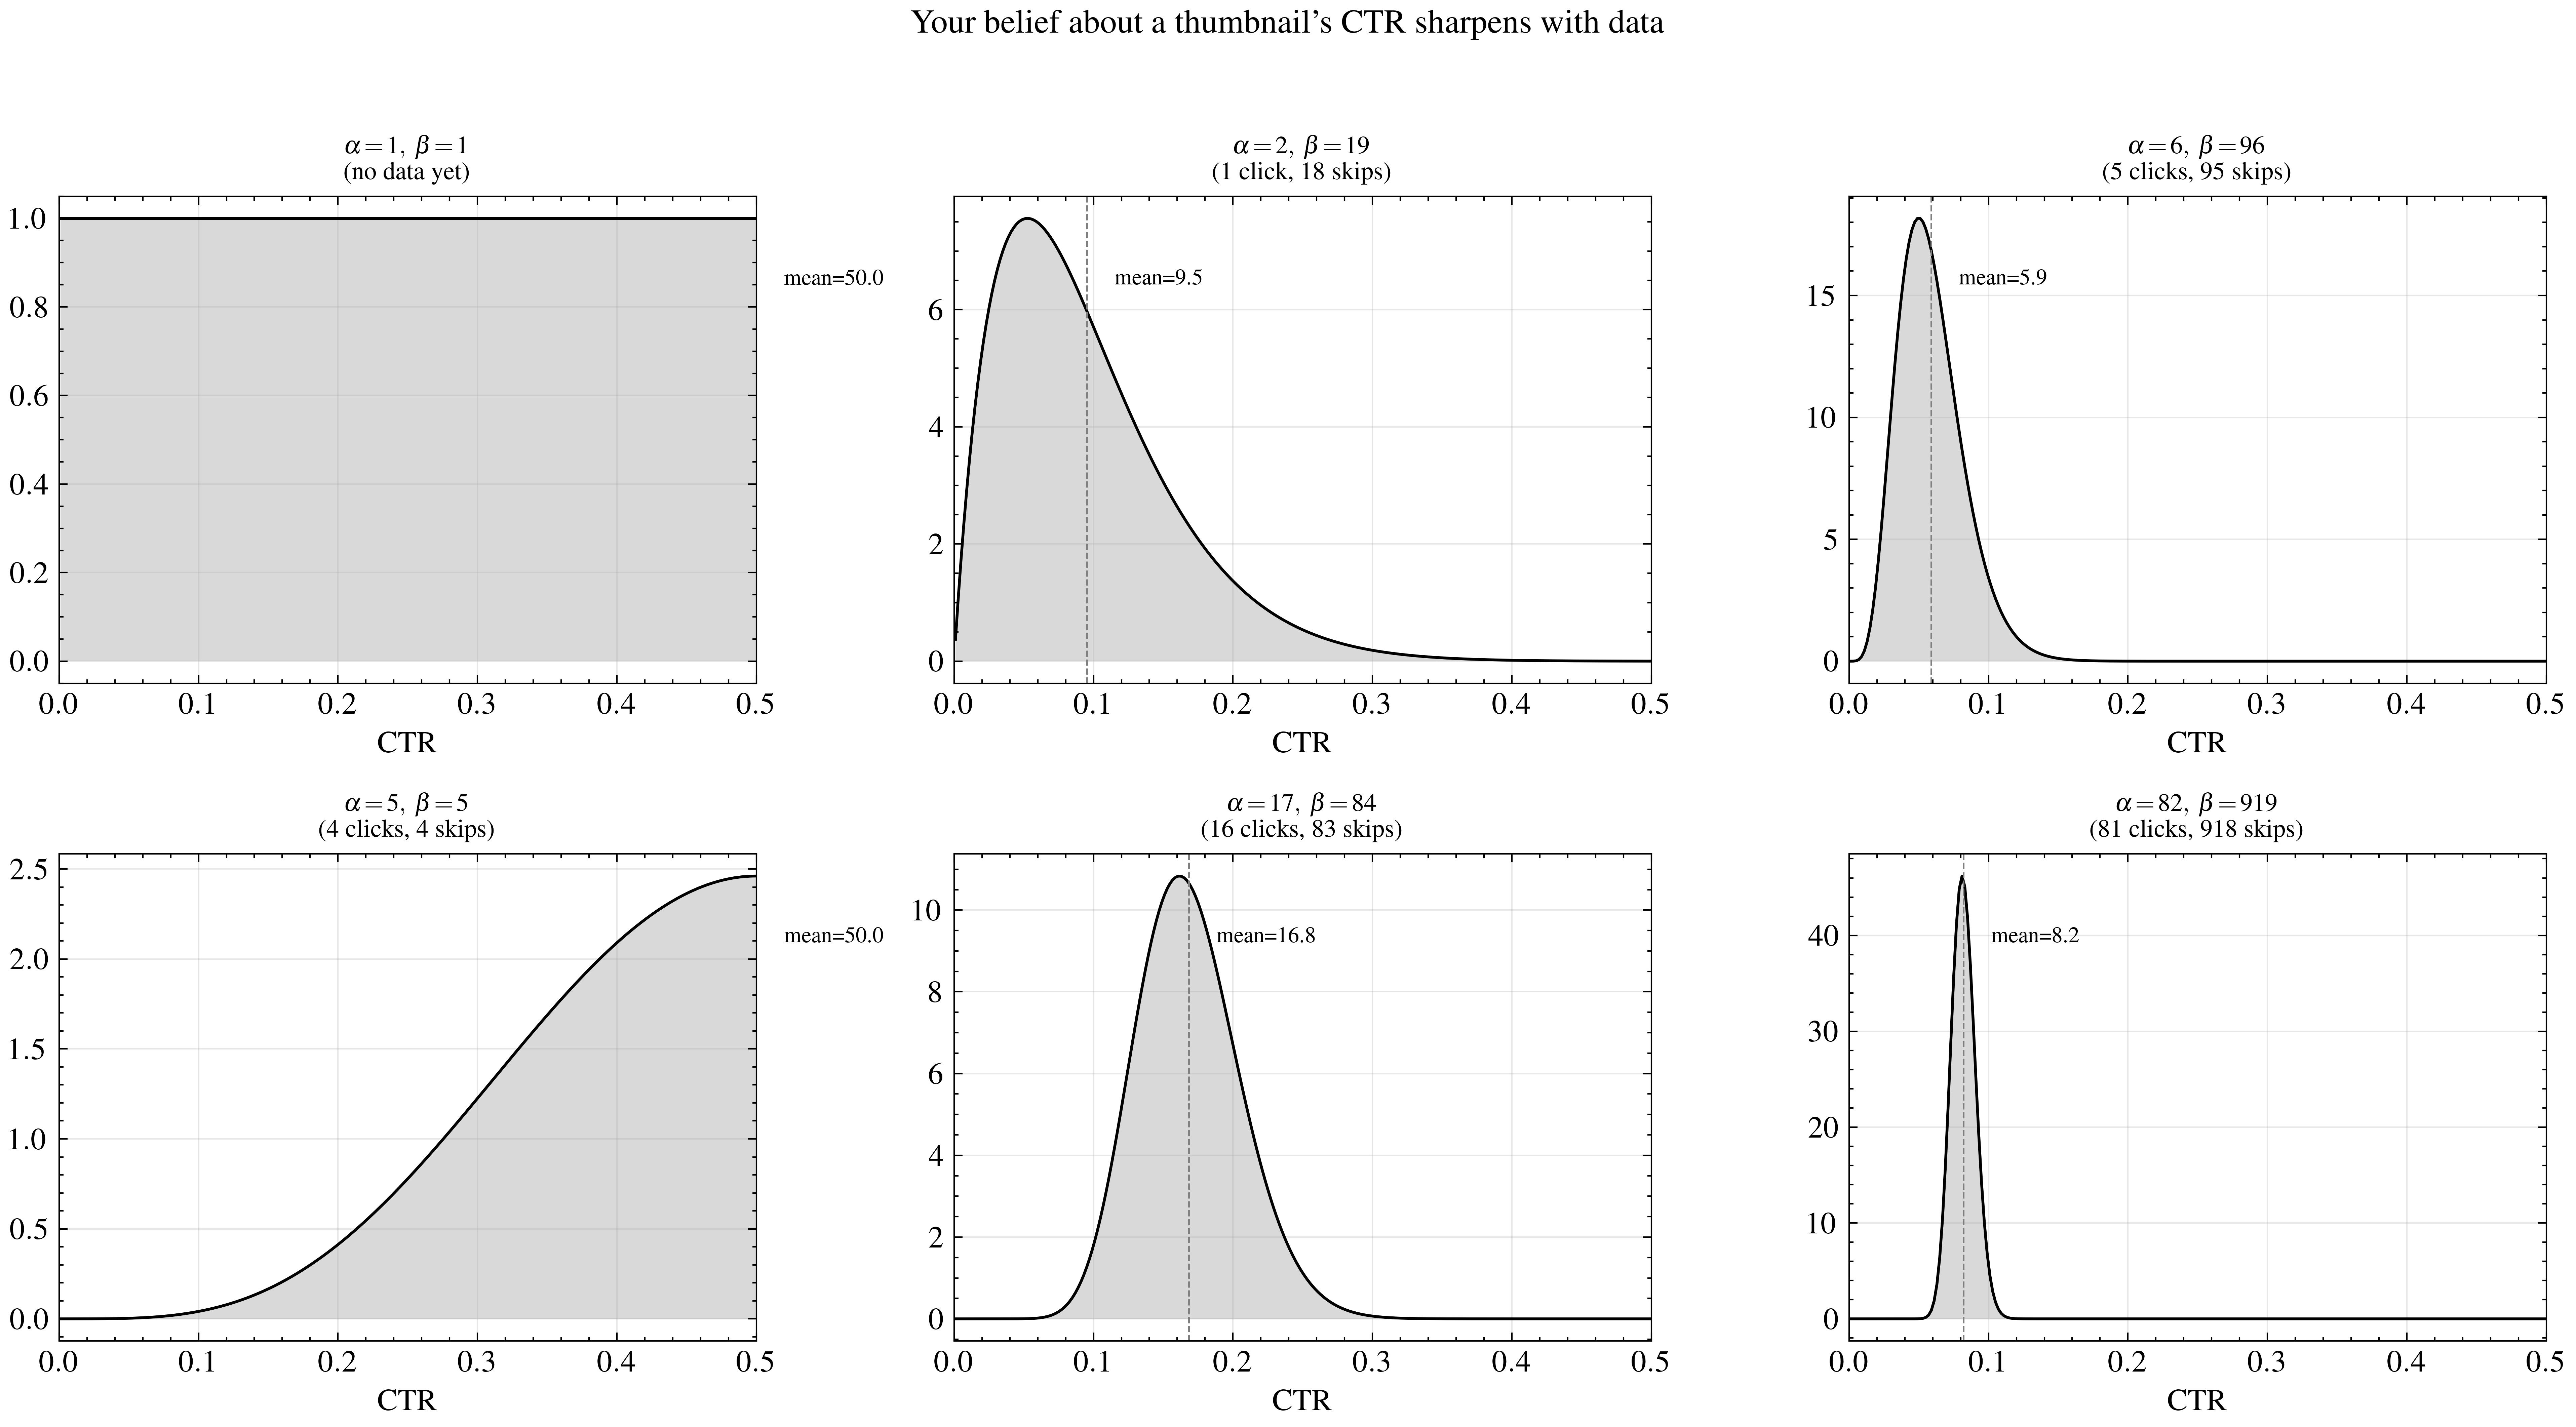

Wide distribution = uncertain -> Thompson Sampling explores this thumbnail more.
Narrow distribution = confident -> draws cluster near truth -> predictable.


In [12]:
# Beta distribution at different stages of learning
fig, axes = plt.subplots(2, 3, figsize=(13, 7))
x = np.linspace(0.001, 0.999, 500)

scenarios = [
    (1, 1,   r'$\alpha\!=\!1,\;\beta\!=\!1$' + '\n(no data yet)'),
    (2, 19,  r'$\alpha\!=\!2,\;\beta\!=\!19$' + '\n(1 click, 18 skips)'),
    (6, 96,  r'$\alpha\!=\!6,\;\beta\!=\!96$' + '\n(5 clicks, 95 skips)'),
    (5, 5,   r'$\alpha\!=\!5,\;\beta\!=\!5$' + '\n(4 clicks, 4 skips)'),
    (17, 84, r'$\alpha\!=\!17,\;\beta\!=\!84$' + '\n(16 clicks, 83 skips)'),
    (82, 919,r'$\alpha\!=\!82,\;\beta\!=\!919$' + '\n(81 clicks, 918 skips)'),
]

for ax, (a, b, title) in zip(axes.flat, scenarios):
    y = stats.beta.pdf(x, a, b)
    ax.plot(x, y, 'k-', lw=1.0)
    ax.fill_between(x, y, alpha=0.15)
    mean = a/(a+b)
    ax.axvline(mean, ls='--', color='grey', lw=0.6)
    ax.text(mean + 0.02, max(y)*0.85, f'mean={mean:.1%}', fontsize=8)
    ax.set_title(title, fontsize=9)
    ax.set_xlim(0, 0.5)
    ax.set_xlabel('CTR')

plt.suptitle("Your belief about a thumbnail's CTR sharpens with data", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("Wide distribution = uncertain -> Thompson Sampling explores this thumbnail more.")
print("Narrow distribution = confident -> draws cluster near truth -> predictable.")

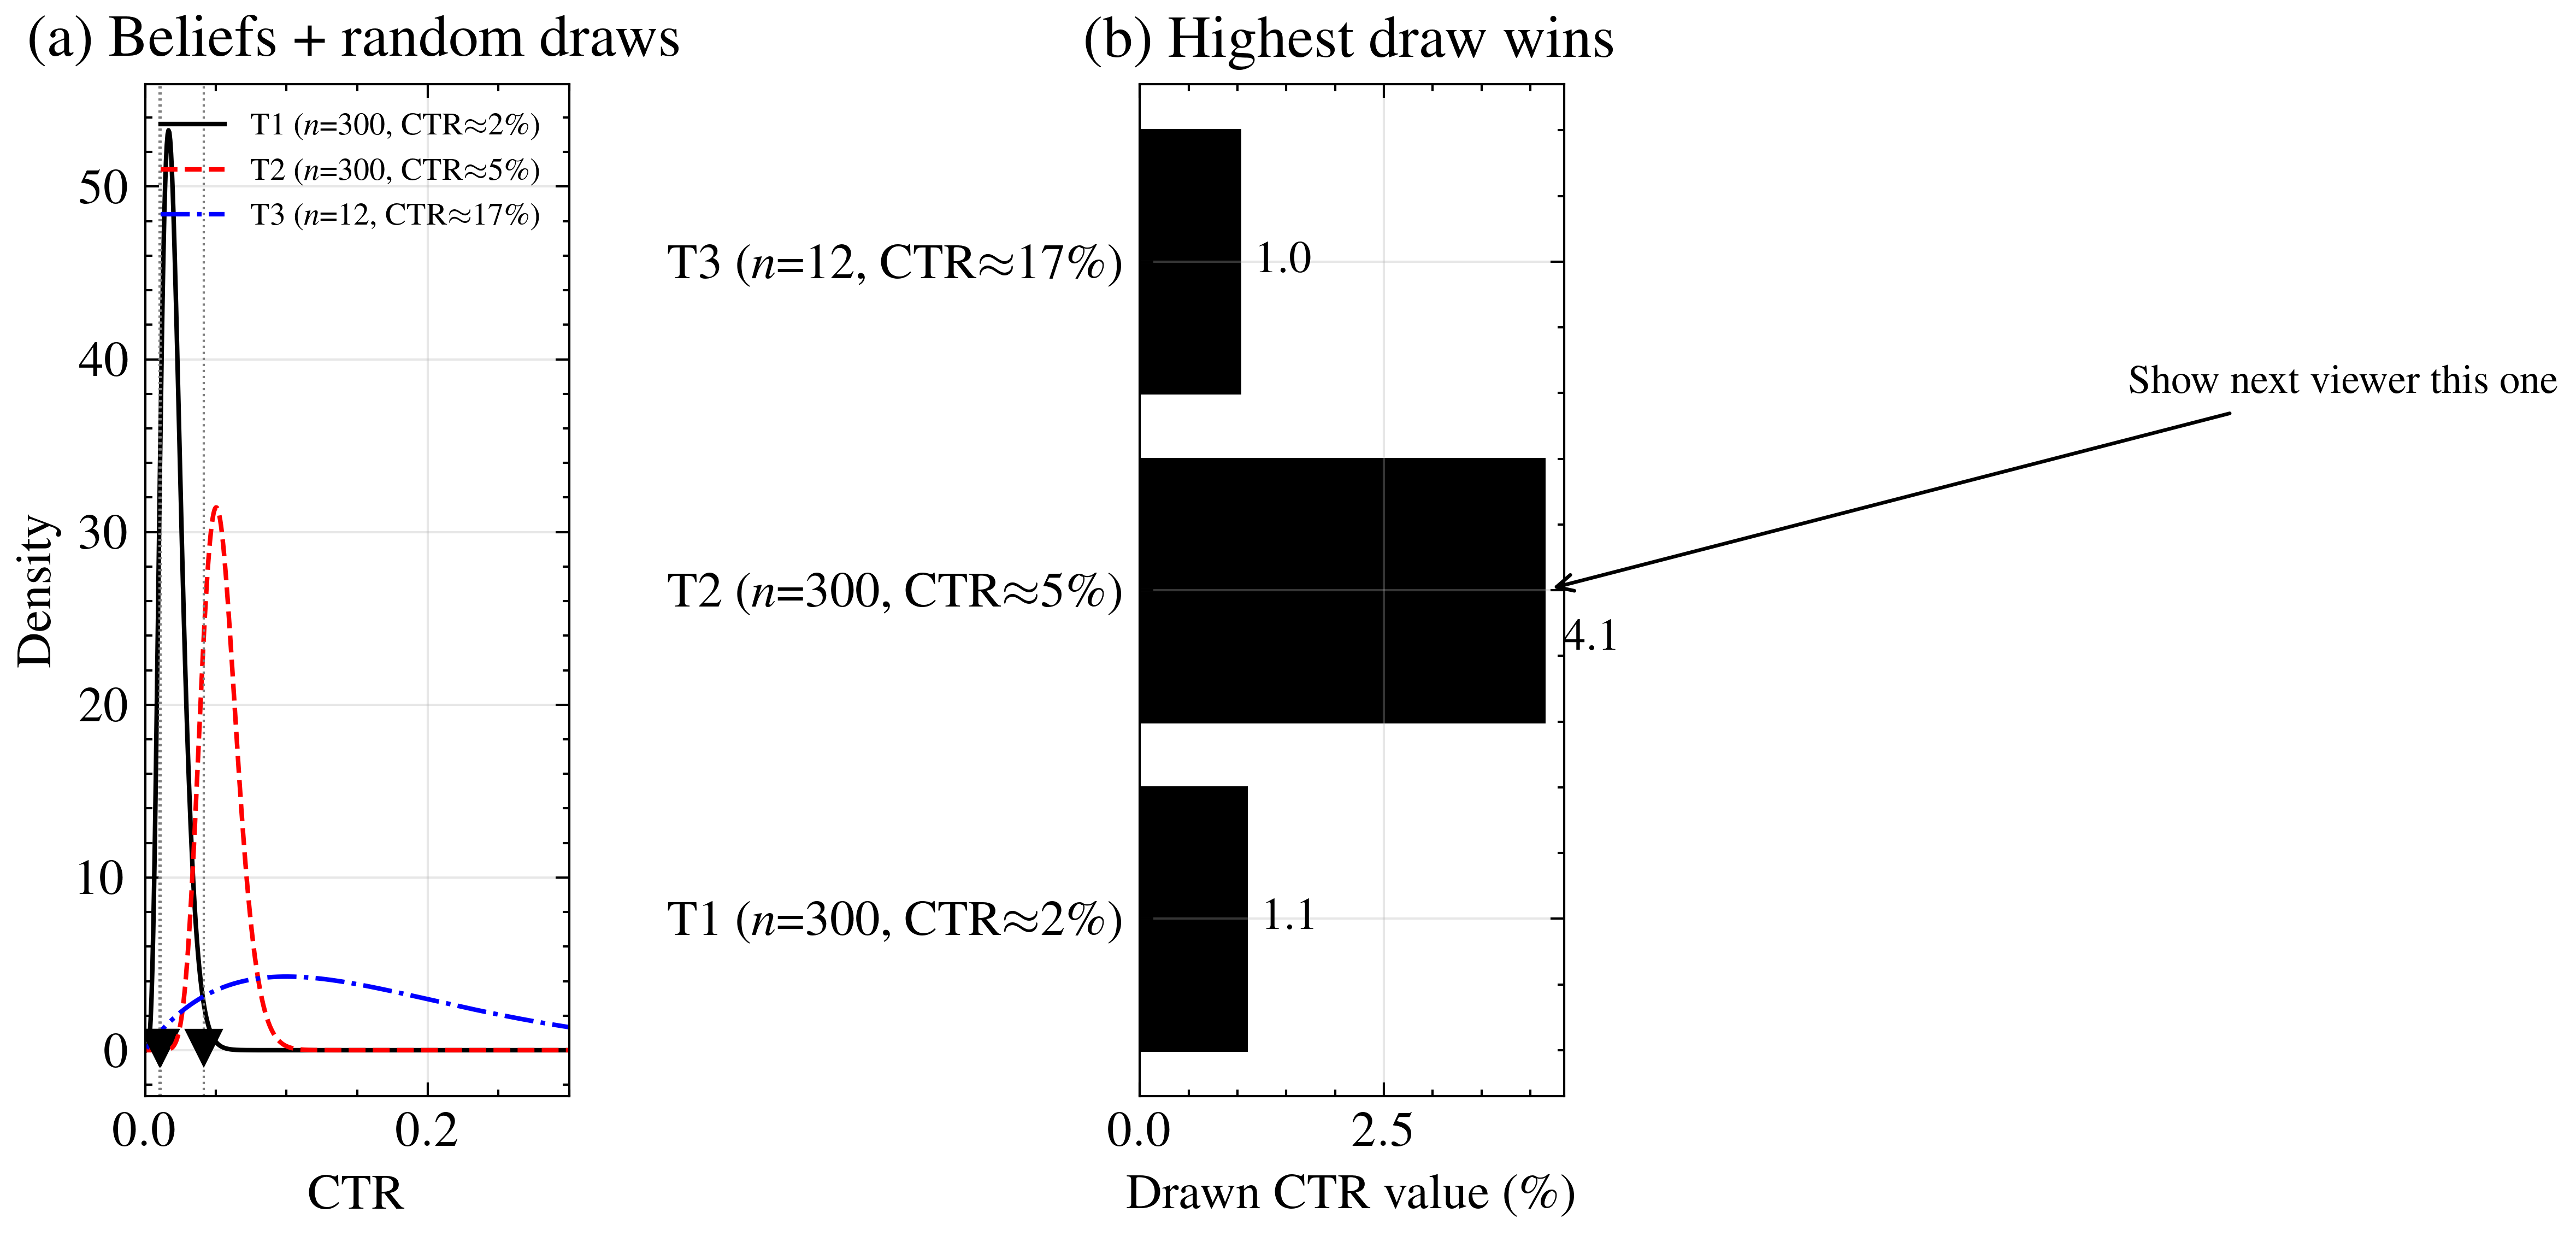

Draws: T1=1.091%, T2=4.138%, T3=1.023%
T3 (12 impressions, wide belief) drew high -> gets explored!


In [18]:
# One round of Thompson Sampling
np.random.seed(123)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.linspace(0.001, 0.30, 500)

arms = [
    (6, 296, r'T1 ($n$=300, CTR$\approx$2\%)'),
    (16, 284, r'T2 ($n$=300, CTR$\approx$5\%)'),
    (2, 10,  r'T3 ($n$=12, CTR$\approx$17\%)'),
]
linestyles = ['-', '--', '-.']
samples = []

ax = axes[0]
for (a,b,name), ls in zip(arms, linestyles):
    y = stats.beta.pdf(x, a, b)
    ax.plot(x, y, ls=ls, lw=1.0, label=name)
    s = np.random.beta(a, b)
    samples.append(s)
    ax.axvline(s, ls=':', lw=0.5, color='grey')
    ax.plot(s, 0.2, 'v', markersize=7, color='black')
ax.set_xlabel('CTR'); ax.set_ylabel('Density')
ax.set_title('(a) Beliefs + random draws')
ax.legend(fontsize=7, loc='upper right')
ax.set_xlim(0, 0.30)

ax = axes[1]
names_ts = [a[2] for a in arms]
bars = ax.barh(names_ts, [s*100 for s in samples], edgecolor='black', linewidth=0.6)
winner = np.argmax(samples)
bars[winner].set_hatch('///')
for i, s in enumerate(samples):
    offset = 0.15 if i == winner else 0
    ax.text(s*100+0.2, i - offset, f'{s:.1%}', va='center', fontsize=10)
ax.set_xlabel('Drawn CTR value (\\%)')
ax.set_title('(b) Highest draw wins')
ax.annotate('Show next viewer this one',
            xy=(samples[winner]*100, winner),
            xytext=(samples[winner]*100+6, winner+0.6),
            fontsize=9, fontweight='bold',
            arrowprops=dict(arrowstyle='->', lw=0.8))

plt.tight_layout()
plt.show()

print(f"Draws: T1={samples[0]:.3%}, T2={samples[1]:.3%}, T3={samples[2]:.3%}")
print(f"T3 (12 impressions, wide belief) drew high -> gets explored!")

In [19]:
class ThompsonSampling:
    def __init__(self, bandit):
        self.bandit = bandit
        self.alpha = np.ones(bandit.K)
        self.beta_ = np.ones(bandit.K)
        self.counts = np.zeros(bandit.K)
        self.regret_history = []
        self.cumulative_regret = 0
        self.belief_history = []
    def run(self, n_steps, track_every=50):
        for t in range(n_steps):
            draws = np.random.beta(self.alpha, self.beta_)
            arm = np.argmax(draws)
            reward = self.bandit.pull(arm)
            self.counts[arm] += 1
            if reward: self.alpha[arm] += 1
            else:      self.beta_[arm] += 1
            self.cumulative_regret += self.bandit.best_prob - self.bandit.probs[arm]
            self.regret_history.append(self.cumulative_regret)
            if t % track_every == 0:
                self.belief_history.append((t, self.alpha.copy(), self.beta_.copy()))

print("ThompsonSampling defined.")

ThompsonSampling defined.


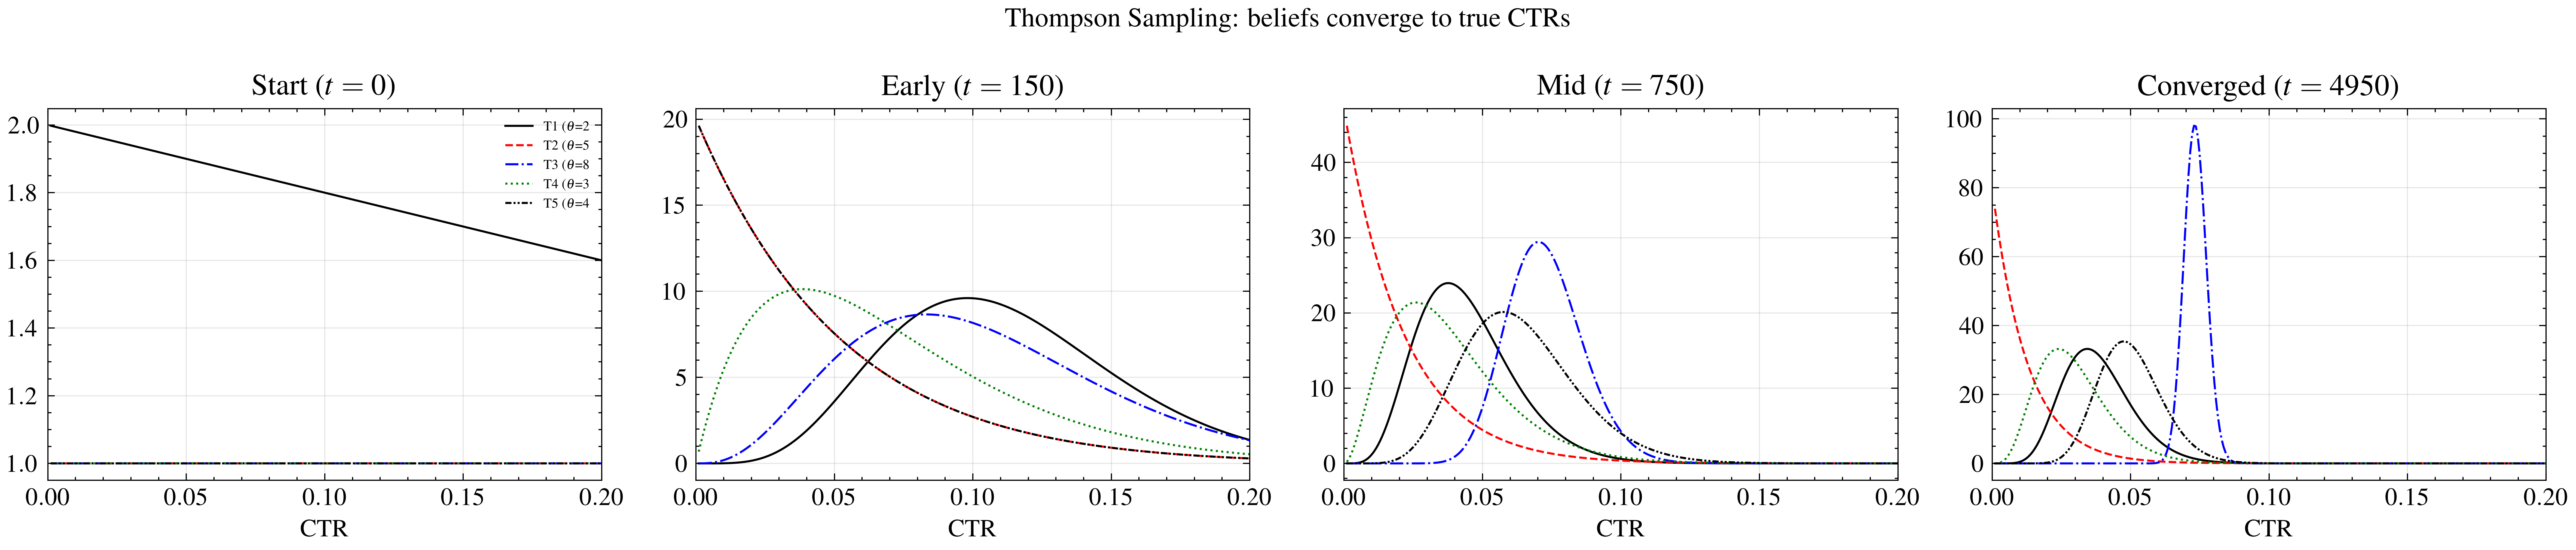

At t=0: flat beliefs -> 'any CTR is equally plausible'
Converged: sharp peaks near true values. T3 (8%) dominates.


In [20]:
# Beliefs converge over time
np.random.seed(42)

bandit = BernoulliBandit([0.02, 0.05, 0.08, 0.03, 0.04])
thumb_names = ['T1', 'T2', 'T3', 'T4', 'T5']
ts = ThompsonSampling(bandit)
ts.run(5000, track_every=50)

checkpoints = [0, 3, 15, -1]
checkpoint_labels = ['Start', 'Early', 'Mid', 'Converged']
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
x = np.linspace(0.001, 0.20, 300)
ls_list = ['-', '--', '-.', ':', (0,(3,1,1,1,1,1))]

for ax, ci, clabel in zip(axes, checkpoints, checkpoint_labels):
    t_val, alphas, betas = ts.belief_history[ci]
    for i in range(bandit.K):
        y = stats.beta.pdf(x, alphas[i], betas[i])
        ax.plot(x, y, ls=ls_list[i], lw=0.9,
                label=rf'{thumb_names[i]} ($\theta$={bandit.probs[i]:.0%})' if ci==0 else None)
    ax.set_title(f'{clabel} ($t={t_val}$)')
    ax.set_xlim(0, 0.20); ax.set_xlabel('CTR')

axes[0].legend(fontsize=6, loc='upper right')
plt.suptitle('Thompson Sampling: beliefs converge to true CTRs', fontsize=12)
plt.tight_layout()
plt.show()

print("At t=0: flat beliefs -> 'any CTR is equally plausible'")
print("Converged: sharp peaks near true values. T3 (8%) dominates.")

---
## 6. Head-to-Head Comparison

All three algorithms on the same 5-thumbnail problem, 10,000 impressions, averaged over 30 runs.

In [21]:
np.random.seed(42)

bandit = BernoulliBandit([0.02, 0.05, 0.08, 0.03, 0.04])
n_steps = 10000
n_trials = 30

all_regrets = {'EG': [], 'UCB': [], 'TS': []}
all_counts  = {'EG': [], 'UCB': [], 'TS': []}

for trial in range(n_trials):
    np.random.seed(trial * 77 + 13)

    eg = EpsilonGreedy(bandit, epsilon=0.1); eg.run(n_steps)
    all_regrets['EG'].append(eg.regret_history)
    all_counts['EG'].append(eg.counts.copy())

    ucb = UCB1(bandit); ucb.run(n_steps)
    all_regrets['UCB'].append(ucb.regret_history)
    all_counts['UCB'].append(ucb.counts.copy())

    ts_s = ThompsonSampling(bandit); ts_s.run(n_steps)
    all_regrets['TS'].append(ts_s.regret_history)
    all_counts['TS'].append(ts_s.counts.copy())

print(f"Done: {n_trials} trials x {n_steps} impressions each.")

Done: 30 trials x 10000 impressions each.


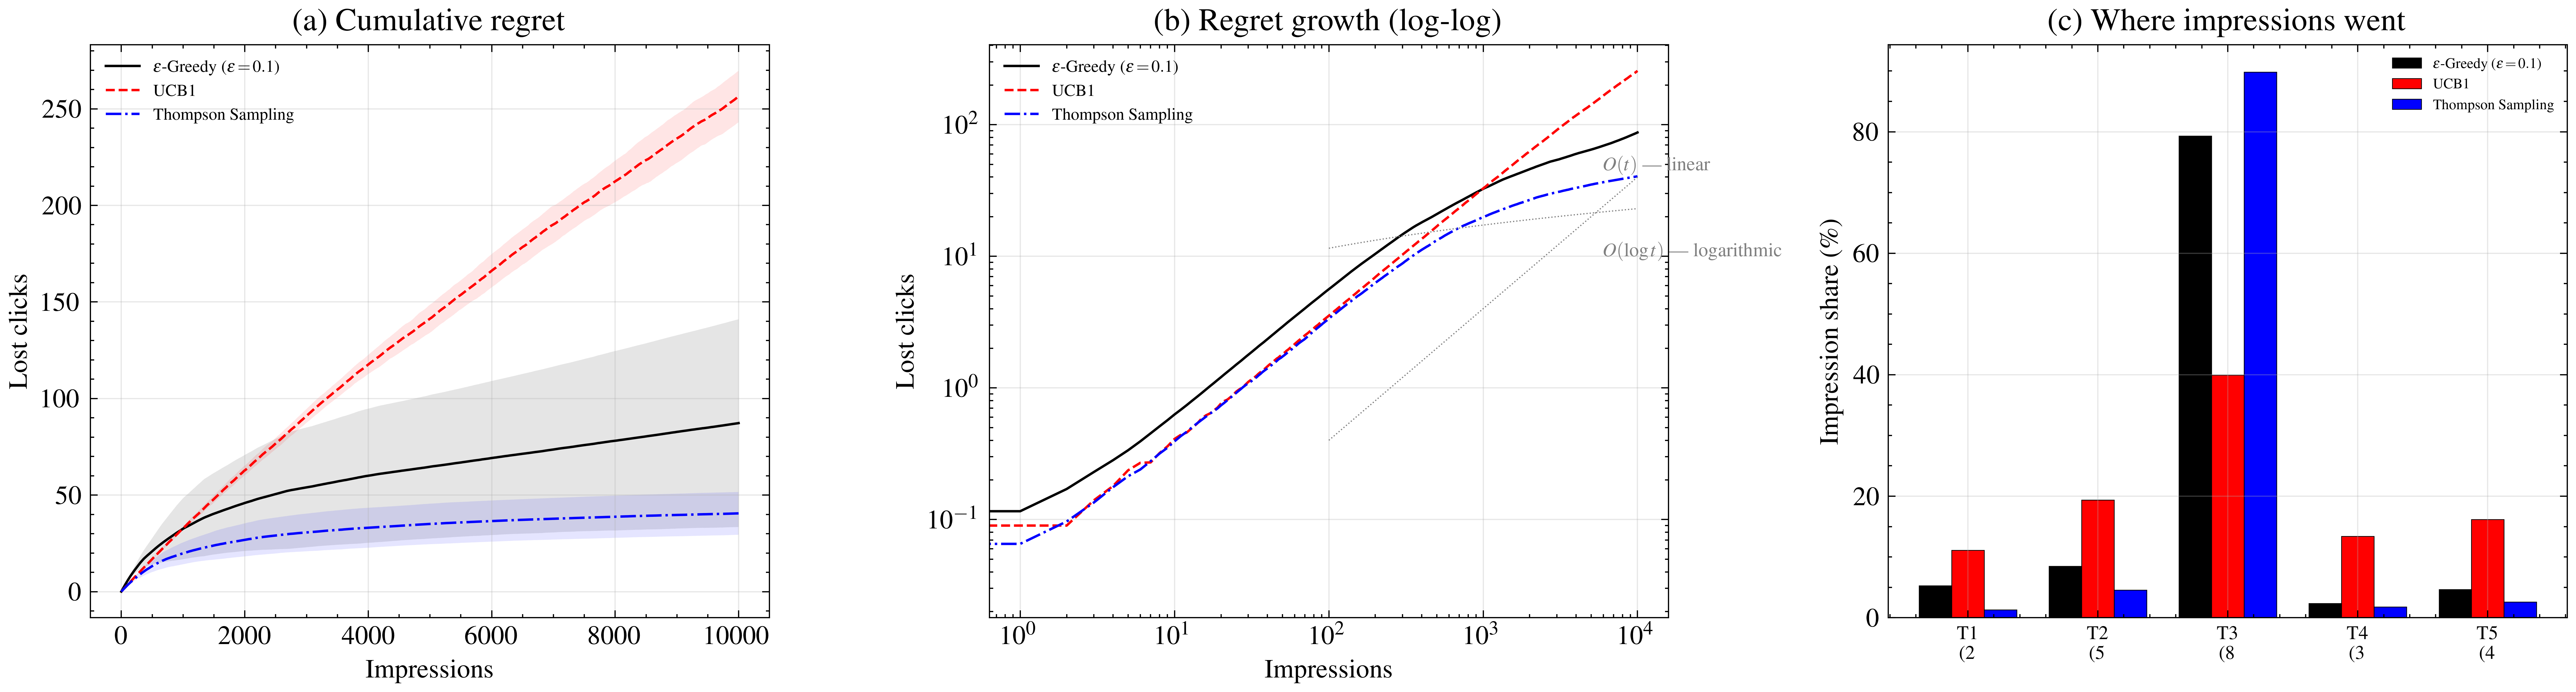


Final lost clicks (mean +/- std, 30 trials):
  $\varepsilon$-Greedy ($\varepsilon\!=\!0.1$): 87.3 +/- 53.8
  UCB1                                      : 256.4 +/- 13.3
  Thompson Sampling                         : 40.5 +/- 11.1

Key results:
  - eps-Greedy: linear regret. Never stops wasting 10% on random thumbnails.
  - UCB1 & Thompson: logarithmic. Lock onto T3 (8%) quickly.
  - Thompson typically achieves the lowest total regret.


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

thumb_names = ['T1', 'T2', 'T3', 'T4', 'T5']
labels = {'EG': r'$\varepsilon$-Greedy ($\varepsilon\!=\!0.1$)', 'UCB': 'UCB1', 'TS': 'Thompson Sampling'}
styles = {'EG': '-', 'UCB': '--', 'TS': '-.'}

# (a) Cumulative regret
ax = axes[0]
for key in all_regrets:
    mean = np.mean(all_regrets[key], axis=0)
    std  = np.std(all_regrets[key], axis=0)
    ax.plot(mean, ls=styles[key], lw=1.0, label=labels[key])
    ax.fill_between(range(n_steps), mean-std, mean+std, alpha=0.1)
ax.set_xlabel('Impressions')
ax.set_ylabel('Lost clicks')
ax.set_title('(a) Cumulative regret')
ax.legend(fontsize=7)

# (b) Log-log
ax = axes[1]
for key in all_regrets:
    mean = np.mean(all_regrets[key], axis=0)
    ax.plot(mean, ls=styles[key], lw=1.0, label=labels[key])
ax.set_xlabel('Impressions'); ax.set_ylabel('Lost clicks')
ax.set_title('(b) Regret growth (log-log)')
ax.set_xscale('log'); ax.set_yscale('log')
ax.legend(fontsize=7)
t_ref = np.arange(100, n_steps)
ax.plot(t_ref, t_ref*0.004, ':', lw=0.5, color='grey')
ax.plot(t_ref, np.log(t_ref)*2.5, ':', lw=0.5, color='grey')
ax.text(6000, 45, r'$O(t)$ — linear', fontsize=8, color='grey')
ax.text(6000, 10, r'$O(\log t)$ — logarithmic', fontsize=8, color='grey')

# (c) Impression distribution
ax = axes[2]
x_pos = np.arange(bandit.K)
width = 0.25
for i, key in enumerate(all_counts):
    mean_frac = np.mean(all_counts[key], axis=0) / n_steps
    ax.bar(x_pos + (i-1)*width, mean_frac*100, width, label=labels[key],
           edgecolor='black', linewidth=0.3)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{t}\n({p:.0%})' for t, p in zip(thumb_names, bandit.probs)], fontsize=8)
ax.set_ylabel('Impression share (\\%)')
ax.set_title('(c) Where impressions went')
ax.legend(fontsize=6)

plt.tight_layout()
plt.show()

print("\nFinal lost clicks (mean +/- std, 30 trials):")
for key in all_regrets:
    finals = [r[-1] for r in all_regrets[key]]
    print(f"  {labels[key]:42s}: {np.mean(finals):.1f} +/- {np.std(finals):.1f}")

print("\nKey results:")
print("  - eps-Greedy: linear regret. Never stops wasting 10% on random thumbnails.")
print("  - UCB1 & Thompson: logarithmic. Lock onto T3 (8%) quickly.")
print("  - Thompson typically achieves the lowest total regret.")

---
## 7. Summary

| Algorithm | How it explores | Regret | Key property |
|---|---|---|---|
| $\varepsilon$-Greedy | Randomly — wastes impressions on known-bad thumbnails | Linear $O(T)$ | Simple but inefficient |
| UCB1 | Targets uncertain thumbnails via Hoeffding-derived confidence bound | Logarithmic $O(\log T)$ | Deterministic, theoretically grounded |
| Thompson Sampling | Draws from belief distributions; uncertain thumbnails can "win" by chance | Logarithmic $O(\log T)$ | Automatic, typically lowest regret |


